#Dual-Encoder U-Net with Concatenation-Based Fusion


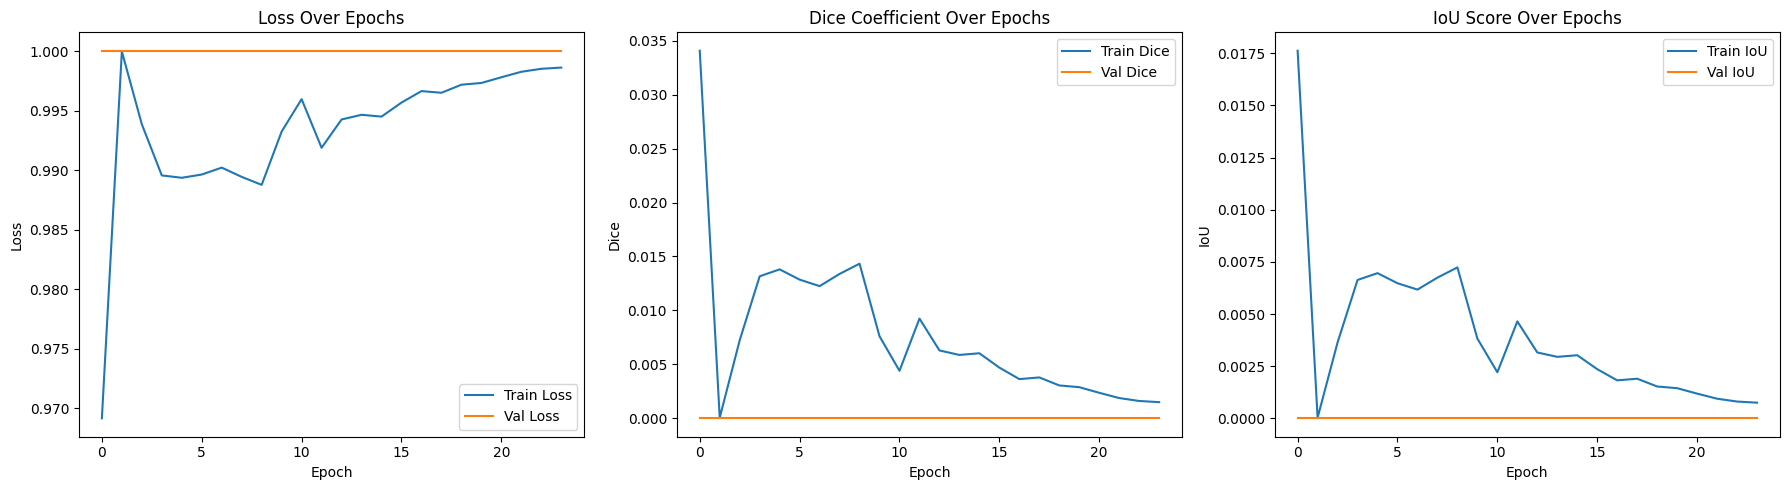

Architecture explanation:
Architecture in Your Code
1. Inputs
Two separate inputs:

input_a → goes into Encoder A (meant for MRI-pretrained weights, frozen later).

input_b → goes into Encoder B (trainable, for CT data).

Both have shape (512, 512, 1).

2. Encoder Blocks
Function: encoder_block → runs:

conv_block → two Conv2D layers + Dropout (0.5 each).

MaxPooling2D to downsample.

Encoder A:

4 stages: A_conv00, A_conv10, A_conv20, A_conv30.

Encoder B:

4 stages: B_conv00, B_conv10, B_conv20, B_conv30.

Each stage doubles the filter size (32 → 64 → 128 → 256).

3. Bottleneck Fusion
Takes the deepest features from both encoders (pa3 and pb3 after pooling).

Fusion method: Concatenate along the channel axis.

Processes the concatenated features with another conv_block (conv40) at 512 filters.

4. Decoder Path
Standard U-Net style decoder with Conv2DTranspose (upsampling) followed by concatenation with skip connections:

Each decoder level merges:

Upsampled features

Corresponding skip from Encoder A

Corresponding skip from Encoder B

Example at level 3:
merge3 = Concatenate([u3, xa3, xb3])

After merging, runs conv_block to refine.

5. Output Layer
Final Conv2D with 1 filter + sigmoid activation → produces segmentation mask.

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util
import cv2
import gc
from tensorflow.keras.callbacks import EarlyStopping

# === DICOMDataGen ===
class DICOMDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_ids, img_path, mask_path, batch_size=4, image_size=512, shuffle=True):
        self.ids = image_ids
        self.img_path = img_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __load__(self, item):
        image = cv2.imread(os.path.join(self.img_path, item), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        mask = cv2.imread(os.path.join(self.mask_path, item), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        mask = (mask >= 255).astype(np.float32)

        image = cv2.resize(image, (self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        return np.expand_dims(image, axis=-1), np.expand_dims(mask, axis=-1)

    def __getitem__(self, index):
        batch_ids = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        images, masks = zip(*(self.__load__(i) for i in batch_ids))
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.ids)
        gc.collect()

    def __len__(self):
        return int(np.ceil(len(self.ids) / self.batch_size))


# === Metrics and Loss Functions ===
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)



def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)




##In-evaluation

In [ ]:
# === Dual-Encoder evaluation using your DICOMDataGen (average-only, no saving) ===
import os, gc, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util
import cv2

# ---------- Your DICOMDataGen (returns (images, masks)) ----------
class DICOMDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_ids, img_path, mask_path, batch_size=4, image_size=512, shuffle=True):
        self.ids = image_ids
        self.img_path = img_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __load__(self, item):
        image = cv2.imread(os.path.join(self.img_path, item), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        mask  = cv2.imread(os.path.join(self.mask_path, item),  cv2.IMREAD_GRAYSCALE).astype(np.float32)
        mask  = (mask >= 255).astype(np.float32)
        image = cv2.resize(image, (self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask,  (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)
        return np.expand_dims(image, axis=-1), np.expand_dims(mask, axis=-1)

    def __getitem__(self, index):
        batch_ids = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        images, masks = zip(*(self.__load__(i) for i in batch_ids))
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.ids)
        gc.collect()

    def __len__(self):
        return int(np.ceil(len(self.ids) / self.batch_size))

# ---------- Paths ----------
ARCH_PATH  = "/content/drive/MyDrive/track3/DualEncoderUNet.py"
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_shapeprior_trained (1).h5"
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"

IMG_SIZE   = 512
BATCH_SIZE = 4
THRESH     = 0.5

# PNG-only? Replace this block with endswith(".png") if needed.
valid_ext = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
image_ids = sorted([
    f for f in os.listdir(IMG_DIR)
    if f.lower().endswith(valid_ext) and os.path.exists(os.path.join(MASK_DIR, f))
])

# ---------- Build generator (no shuffle) ----------
test_gen = DICOMDataGen(image_ids, IMG_DIR, MASK_DIR,
                        batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=False)

# ---------- Load DualEncoderUNet builder ----------
spec = importlib.util.spec_from_file_location("DualEncoderUNet", ARCH_PATH)
dual_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dual_module)
build_dual_encoder_unet = dual_module.build_dual_encoder_unet

# ---------- Load model (saved model or weights) ----------
from tensorflow.keras.models import load_model
try:
    model = load_model(MODEL_PATH, compile=False)
except Exception:
    model = build_dual_encoder_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1), filters=[32, 64, 128, 256, 512])
    model.load_weights(MODEL_PATH)

# ---------- Metrics ----------
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1).astype(np.float32)
    y_pred_f = y_pred.reshape(-1).astype(np.float32)
    inter = np.sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1).astype(np.float32)
    y_pred_f = y_pred.reshape(-1).astype(np.float32)
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

# ---------- Inference (collect everything first) ----------
all_imgs, all_masks, all_preds_prob = [], [], []

for b in range(len(test_gen)):
    imgs, gts = test_gen[b]                          # (B,H,W,1)
    zeros = np.zeros_like(imgs, dtype=np.float32)    # encoder A (mirrors training)
    preds = model.predict([zeros, imgs], verbose=0)  # (B,H,W,1)

    all_imgs.extend(list(imgs[...,0]))
    all_masks.extend(list(gts[...,0]))
    all_preds_prob.extend(list(preds[...,0]))

# ---------- Compute per-image metrics at the end, then average ----------
masks_all = np.array(all_masks, dtype=np.float32)[..., None]                         # (N,H,W,1)
preds_all = (np.array(all_preds_prob, dtype=np.float32)[..., None] >= THRESH).astype(np.float32)

per_img_dice = [dice_score(masks_all[i], preds_all[i]) for i in range(len(masks_all))]
per_img_iou  = [iou_score(masks_all[i],  preds_all[i]) for i in range(len(masks_all))]

avg_dice = float(np.mean(per_img_dice)) if per_img_dice else 0.0
avg_iou  = float(np.mean(per_img_iou))  if per_img_iou  else 0.0

print(f"\nAverage Dice (per-image mean): {avg_dice:.4f}")
print(f"Average IoU  (per-image mean): {avg_iou:.4f}\n")

# ---------- Display ALL results (Image | GT | Pred binary) ----------
N = len(all_imgs)
for i in range(N):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(all_imgs[i], cmap='gray')
    plt.title(f"Image {i+1}: {test_gen.ids[i]}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(all_masks[i], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow((all_preds_prob[i] >= THRESH).astype(np.float32), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

#cross evaluation

In [ ]:
# === Dual-Encoder evaluation using your DICOMDataGen (SQU only, average-only, no saving) ===
import os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf, importlib.util

# --- paths ---
ARCH_PATH  = "/content/drive/MyDrive/track3/DualEncoderUNet.py"
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_shapeprior_trained (1).h5"
IMG_DIR    = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/images"  # SQU only
MASK_DIR   = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/masks"   # SQU only

IMG_SIZE   = 512
BATCH_SIZE = 4
THRESH     = 0.5

# --- PNG-only ids present in both folders ---
image_ids = sorted([
    f for f in os.listdir(IMG_DIR)
    if f.lower().endswith(".png") and os.path.exists(os.path.join(MASK_DIR, f))
])

# --- build generator (uses your class; no shuffle) ---
test_gen = DICOMDataGen(image_ids, IMG_DIR, MASK_DIR,
                        batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=False)

# --- load DualEncoderUNet builder ---
spec = importlib.util.spec_from_file_location("DualEncoderUNet", ARCH_PATH)
dual_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dual_module)
build_dual_encoder_unet = dual_module.build_dual_encoder_unet

# --- load model (try full .h5 first; fallback to build+weights) ---
from tensorflow.keras.models import load_model
try:
    model = load_model(MODEL_PATH, compile=False)
except Exception:
    model = build_dual_encoder_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1), filters=[32, 64, 128, 256, 512])
    model.load_weights(MODEL_PATH)

# --- metrics (your formulas) ---
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1).astype(np.float32)
    y_pred_f = y_pred.reshape(-1).astype(np.float32)
    inter = np.sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1).astype(np.float32)
    y_pred_f = y_pred.reshape(-1).astype(np.float32)
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

# --- inference (collect everything first) ---
all_imgs, all_masks, all_preds_prob = [], [], []

for b in range(len(test_gen)):
    imgs, gts = test_gen[b]                          # (B,H,W,1)
    zeros = np.zeros_like(imgs, dtype=np.float32)    # encoder A
    preds = model.predict([zeros, imgs], verbose=0)  # (B,H,W,1)

    all_imgs.extend(list(imgs[...,0]))
    all_masks.extend(list(gts[...,0]))
    all_preds_prob.extend(list(preds[...,0]))

# --- compute per-image Dice/IoU at the end, then average ---
masks_all = np.array(all_masks, dtype=np.float32)[..., None]                         # (N,H,W,1)
preds_all = (np.array(all_preds_prob, dtype=np.float32)[..., None] >= THRESH).astype(np.float32)

per_img_dice = [dice_score(masks_all[i], preds_all[i]) for i in range(len(masks_all))]
per_img_iou  = [iou_score(masks_all[i],  preds_all[i]) for i in range(len(masks_all))]

avg_dice = float(np.mean(per_img_dice)) if per_img_dice else 0.0
avg_iou  = float(np.mean(per_img_iou))  if per_img_iou  else 0.0
print(f"\nSQU — Average Dice (per-image mean): {avg_dice:.4f}")
print(f"SQU — Average IoU  (per-image mean): {avg_iou:.4f}\n")

# --- display ALL results (Image | GT | Pred binary) ---
N = len(all_imgs)
for i in range(N):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(all_imgs[i], cmap='gray')
    plt.title(f"SQU — Image {i+1}: {test_gen.ids[i]}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(all_masks[i], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(preds_all[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

#Adapted Dual-Encoder Shared-Tail U-Net (ADEST-U-Net)



Here’s a clear, straight description of arch 3: DualEncoderSharedTail_Adapted.

Inputs
Single input: input_ct with shape (512, 512, 1).

Adaptation (for Encoder A)
adapt_conv: Conv2D(1×1) on input_ct.

adapt_bn: BatchNormalization on the adapted map.

The adapted tensor is the input to Encoder A.

Encoder blocks (common pattern)
encoder_block(x, f, name):
Conv2D(f,3,relu) → Dropout(rate) → Conv2D(f,3,relu) → Dropout(rate) → MaxPool(2×2)
Returns: (features_before_pool, pooled_features).

Encoder A (operates on adapted CT)
A_conv00: from adapt_bn → outputs xa0, pa0

A_conv10: from pa0 → xa1, pa1

A_conv20: from pa1 → xa2, pa2

A_conv30: from pa2 → xa3, pa3

A_conv40: conv_block on pa3 → xa4

Encoder B (operates on raw CT)
B_conv00: from input_ct → xb0, pb0

B_conv10: from pb0 → xb1, pb1

B_conv20: from pb1 → xb2, pb2

B_conv30: from pb2 → xb3, pb3

B_conv40: conv_block on pb3 → xb4

Fusion and Shared Tail
shared_concat: Concatenate([xa4, xb4]) → merged

shared_conv50: encoder_block(merged, filters[4]) → gives skip s1 (pre-pool) and pooled ps1

shared_conv60: conv_block(ps1, filters[4]) → bottleneck s2

Decoder (uses only the shared skip s1)
up3: Conv2DTranspose(filters[3], 2, stride=2) on s2

merge3: Concatenate([up3, s1])

dec_x30: conv_block(..., filters[3])

up2: Conv2DTranspose(filters[2], 2, stride=2) → dec_x20: conv_block(..., filters[2])

up1: Conv2DTranspose(filters[1], 2, stride=2) → dec_x10: conv_block(..., filters[1])

up0: Conv2DTranspose(filters[0], 2, stride=2) → dec_x00: conv_block(..., filters[0])

Output
output: Conv2D(1, 1, activation="sigmoid") on the last decoder feature.

Model: Model(inputs=input_ct, outputs=outputs, name="DualEncoderSharedTail_Adapted").

Spatial scales (for 512×512 input)
Encoders A/B downsample: 512 → 256 → 128 → 64 → 32 (features xa4/xb4 at 32×32).

Shared tail shared_conv50 pools once more: 32 → 16 (bottleneck s2 at 16×16).

Decoder upsamples: 16 → 32 (merge with s1) → 64 → 128 → 256.

Output resolution: 256×256 (as implemented).

Hyperparameters
filters = [32, 64, 128, 256, 512]

dropout_rate (default 0.3) is used in all conv_blocks.

##in evaluation

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred (pred = white on black), 512-metrics only ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_adpted_adapted.h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

# ---- metrics ----
def dice_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    return (2*inter + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    union  = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

def show_triptych(ct, gt, pred_bin, fname=""):
    fig = plt.figure(figsize=(9,3))
    ax1 = plt.subplot(1,3,1); ax1.imshow(ct[...,0], cmap="gray"); ax1.set_title("CT"); ax1.axis("off")
    ax2 = plt.subplot(1,3,2); ax2.imshow(gt[...,0], cmap="gray", vmin=0, vmax=1); ax2.set_title("GT"); ax2.axis("off")
    # Pred as pure mask: white tumor on black background
    ax3 = plt.subplot(1,3,3); ax3.imshow(pred_bin, cmap="gray", vmin=0, vmax=1); ax3.set_title("Pred"); ax3.axis("off")
    if fname: plt.suptitle(fname)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---- load model and 256->512 wrapper ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

dice_list, iou_list = [], []

# ---- inference loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        pb  = (preds[j] >= THRESH).astype(np.float32)  # binary 0/1 at 512
        gt  = msks[j][...,0]                           # 512 GT
        dice_list.append(dice_np(gt, pb))
        iou_list.append(iou_np(gt, pb))

        # 3 columns: CT | GT | Pred(mask-only white on black)
        show_triptych(imgs[j], msks[j], pb, fname=os.path.basename(ip))

    del imgs, msks, x, preds
    gc.collect()

# ---- final summary (512 metrics only; exact format) ----
if dice_list:
    print(f" Mean Dice :  {np.mean(dice_list):.4f}")
    print(f"Mean  IoU :  {np.mean(iou_list):.4f}")


Output hidden; open in https://colab.research.google.com to view.

#cross evaluation

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred (pred = white on black), 512-metrics only ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_adpted_adapted.h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/images"
MASK_DIR   = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/masks"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

# ---- metrics ----
def dice_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    return (2*inter + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    union  = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

def show_triptych(ct, gt, pred_bin, fname=""):
    fig = plt.figure(figsize=(9,3))
    ax1 = plt.subplot(1,3,1); ax1.imshow(ct[...,0], cmap="gray"); ax1.set_title("CT"); ax1.axis("off")
    ax2 = plt.subplot(1,3,2); ax2.imshow(gt[...,0], cmap="gray", vmin=0, vmax=1); ax2.set_title("GT"); ax2.axis("off")
    # Pred as pure mask: white tumor on black background
    ax3 = plt.subplot(1,3,3); ax3.imshow(pred_bin, cmap="gray", vmin=0, vmax=1); ax3.set_title("Pred"); ax3.axis("off")
    if fname: plt.suptitle(fname)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---- load model and 256->512 wrapper ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

dice_list, iou_list = [], []

# ---- inference loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        pb  = (preds[j] >= THRESH).astype(np.float32)  # binary 0/1 at 512
        gt  = msks[j][...,0]                           # 512 GT
        dice_list.append(dice_np(gt, pb))
        iou_list.append(iou_np(gt, pb))

        # 3 columns: CT | GT | Pred(mask-only white on black)
        show_triptych(imgs[j], msks[j], pb, fname=os.path.basename(ip))

    del imgs, msks, x, preds
    gc.collect()

# ---- final summary (512 metrics only; exact format) ----
if dice_list:
    print(f" Mean Dice :  {np.mean(dice_list):.4f}")
    print(f"Mean  IoU :  {np.mean(iou_list):.4f}")


Output hidden; open in https://colab.research.google.com to view.

#arch3:Adapted Dual-Encoder Shared-Tail U-Net (ADEST-U-Net)#

Architecture: Same as Training 1 (dual encoders → shared tail → UNet-style decoder), dropout 0.3, output 256×256.

Initialization: Encoder A loaded from UNet++ (MRI) via layer mapping (frozen → unfrozen); Encoder B trained from scratch on CT.

Preprocessing: CT grayscale → float32/255.0; masks resized (nearest) and binarized >=255.

Warmup (5 epochs): Encoder A frozen; Adam 1e-4; Dice loss; metrics: Dice, IoU.

Fine-tune (up to 80 epochs): Unfreeze Encoder A; Adam 1e-5; Dice + 0.05·MSE(shape prior).
Shape prior = mean of training masks (shape_prior.npy).

Callbacks: EarlyStopping (monitor val_dice_coef, patience 15, restore best) + ReduceLROnPlateau (monitor val_dice_coef, factor 0.5, patience 5, min_lr 1e-7).

Output model: /workspace/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched.h5.

What’s new vs Training 1: More epochs (80 vs 50) and an LR scheduler; architecture and data pipeline unchanged.

##in evaluation

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred (pred = white on black), 512-metrics only ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

# ---- metrics ----
def dice_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    return (2*inter + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    union  = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

def show_triptych(ct, gt, pred_bin, fname=""):
    fig = plt.figure(figsize=(9,3))
    ax1 = plt.subplot(1,3,1); ax1.imshow(ct[...,0], cmap="gray"); ax1.set_title("CT"); ax1.axis("off")
    ax2 = plt.subplot(1,3,2); ax2.imshow(gt[...,0], cmap="gray", vmin=0, vmax=1); ax2.set_title("GT"); ax2.axis("off")
    # Pred as pure mask: white tumor on black background
    ax3 = plt.subplot(1,3,3); ax3.imshow(pred_bin, cmap="gray", vmin=0, vmax=1); ax3.set_title("Pred"); ax3.axis("off")
    if fname: plt.suptitle(fname)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---- load model and 256->512 wrapper ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

dice_list, iou_list = [], []

# ---- inference loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        pb  = (preds[j] >= THRESH).astype(np.float32)  # binary 0/1 at 512
        gt  = msks[j][...,0]                           # 512 GT
        dice_list.append(dice_np(gt, pb))
        iou_list.append(iou_np(gt, pb))

        # 3 columns: CT | GT | Pred(mask-only white on black)
        show_triptych(imgs[j], msks[j], pb, fname=os.path.basename(ip))

    del imgs, msks, x, preds
    gc.collect()

# ---- final summary (512 metrics only; exact format) ----
if dice_list:
    print(f" Mean Dice :  {np.mean(dice_list):.4f}")
    print(f"Mean  IoU :  {np.mean(iou_list):.4f}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred (pred = white on black), 512-metrics only ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/masks"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

# ---- metrics ----
def dice_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    return (2*inter + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    union  = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

def show_triptych(ct, gt, pred_bin, fname=""):
    fig = plt.figure(figsize=(9,3))
    ax1 = plt.subplot(1,3,1); ax1.imshow(ct[...,0], cmap="gray"); ax1.set_title("CT"); ax1.axis("off")
    ax2 = plt.subplot(1,3,2); ax2.imshow(gt[...,0], cmap="gray", vmin=0, vmax=1); ax2.set_title("GT"); ax2.axis("off")
    # Pred as pure mask: white tumor on black background
    ax3 = plt.subplot(1,3,3); ax3.imshow(pred_bin, cmap="gray", vmin=0, vmax=1); ax3.set_title("Pred"); ax3.axis("off")
    if fname: plt.suptitle(fname)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---- load model and 256->512 wrapper ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

dice_list, iou_list = [], []

# ---- inference loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        pb  = (preds[j] >= THRESH).astype(np.float32)  # binary 0/1 at 512
        gt  = msks[j][...,0]                           # 512 GT
        dice_list.append(dice_np(gt, pb))
        iou_list.append(iou_np(gt, pb))

        # 3 columns: CT | GT | Pred(mask-only white on black)
        show_triptych(imgs[j], msks[j], pb, fname=os.path.basename(ip))

    del imgs, msks, x, preds
    gc.collect()

# ---- final summary (512 metrics only; exact format) ----
if dice_list:
    print(f" Mean Dice :  {np.mean(dice_list):.4f}")
    print(f"Mean  IoU :  {np.mean(iou_list):.4f}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred (pred = white on black), 512-metrics only ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/images"
MASK_DIR   = "/content/drive/MyDrive/SQU_split_tumor_80_10_10/test/masks"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# ------------------- METRICS (your versions) -------------------
def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

def show_triptych(ct, gt, pred_bin, fname=""):
    fig = plt.figure(figsize=(9,3))
    ax1 = plt.subplot(1,3,1); ax1.imshow(ct[...,0], cmap="gray"); ax1.set_title("CT"); ax1.axis("off")
    ax2 = plt.subplot(1,3,2); ax2.imshow(gt[...,0], cmap="gray", vmin=0, vmax=1); ax2.set_title("GT"); ax2.axis("off")
    ax3 = plt.subplot(1,3,3); ax3.imshow(pred_bin, cmap="gray", vmin=0, vmax=1); ax3.set_title("Pred"); ax3.axis("off")
    if fname: plt.suptitle(fname)
    plt.tight_layout(); plt.show(); plt.close(fig)

# ---- load model and 256->512 wrapper ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

dice_list, iou_list = [], []

# ---- inference loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        pb  = (preds[j] >= THRESH).astype(np.float32)  # binary 0/1 at 512
        gt  = msks[j][...,0]                           # 512 GT
        dice_list.append(dice_score(gt, pb))
        iou_list.append(iou_score(gt, pb))

        # 3 columns: CT | GT | Pred(mask-only white on black)
        show_triptych(imgs[j], msks[j], pb, fname=os.path.basename(ip))

    del imgs, msks, x, preds
    gc.collect()

# ---- final summary (512 metrics only; exact format) ----
if dice_list:
    print(f" Mean Dice :  {np.mean(dice_list):.4f}")
    print(f"Mean  IoU :  {np.mean(iou_list):.4f}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred + TP/FP/FN overlays & stats (512 only) ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"

SAVE_FIGS       = False                                   # set True to save figures
FIG_OUT_DIR     = "/content/drive/MyDrive/track3/viz"     # folder to save figures if SAVE_FIGS=True
SAVE_STATS_CSV  = False                                   # set True to save stats CSV
STATS_OUT_CSV   = "/content/drive/MyDrive/track3/tp_fp_fn_intensity_stats.csv"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

os.makedirs(FIG_OUT_DIR, exist_ok=True)

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

# ---- metrics ----
def dice_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    return (2*inter + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    union  = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

# ---- load model and 256->512 wrapper (if base outputs <512) ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

dice_list, iou_list = [], []
stats = []   # per-image intensity stats (TP/FP/FN)

# ---- inference + visualization loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        fname = os.path.basename(ip)
        ct    = imgs[j]                  # (512,512,1), normalized [0,1]
        gt    = msks[j][..., 0]          # (512,512)
        pb    = (preds[j] >= THRESH).astype(np.uint8)  # binary 0/1 at 512

        # Metrics
        dice_list.append(dice_np(gt, pb))
        iou_list.append(iou_np(gt, pb))

        # ---------- TP / FP / FN ----------
        TP = (gt == 1) & (pb == 1)
        FP = (gt == 0) & (pb == 1)
        FN = (gt == 1) & (pb == 0)

        # Overlay on original CT
        orig = (ct.squeeze() * 255).astype(np.uint8)
        overlay = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)

        # Draw contours: TP=green, FP=red, FN=blue
        def draw_contours(binary_mask, color_bgr, thickness=2):
            m = (binary_mask.astype(np.uint8)) * 255
            contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                cv2.drawContours(overlay, contours, -1, color_bgr, thickness)

        draw_contours(TP, (0, 255, 0))     # green
        draw_contours(FP, (255, 0, 0))     # red
        draw_contours(FN, (0, 0, 255))     # blue

        # Classification map
        viz_map = np.zeros((img_size, img_size, 3), dtype=np.uint8)
        viz_map[TP] = [0, 255, 0]      # green
        viz_map[FP] = [255, 0, 0]      # red
        viz_map[FN] = [0, 0, 255]      # blue

        # Intensity stats (on original CT)
        tp_vals = orig[TP]
        fp_vals = orig[FP]
        fn_vals = orig[FN]

        stats.append({
            'Image': fname,
            'TP_min': int(np.min(tp_vals)) if tp_vals.size else None,
            'TP_max': int(np.max(tp_vals)) if tp_vals.size else None,
            'TP_mean': float(np.mean(tp_vals)) if tp_vals.size else None,
            'FP_min': int(np.min(fp_vals)) if fp_vals.size else None,
            'FP_max': int(np.max(fp_vals)) if fp_vals.size else None,
            'FP_mean': float(np.mean(fp_vals)) if fp_vals.size else None,
            'FN_min': int(np.min(fn_vals)) if fn_vals.size else None,
            'FN_max': int(np.max(fn_vals)) if fn_vals.size else None,
            'FN_mean': float(np.mean(fn_vals)) if fn_vals.size else None
        })

        # ---------- 3-column figure ----------
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))

        axs[0].imshow(overlay)
        axs[0].set_title(f"{fname}\nTP (Green), FP (Red), FN (Blue)")
        axs[0].axis("off")

        axs[1].imshow(viz_map)
        axs[1].set_title("Classification Map")
        axs[1].axis("off")

        bins = np.arange(0, 257, 10)
        # Safeguard empty arrays for hist (matplotlib errors on empty sometimes)
        if tp_vals.size: axs[2].hist(tp_vals, bins=bins, color='green', label='TP', histtype='step', linewidth=2)
        if fp_vals.size: axs[2].hist(fp_vals, bins=bins, color='red',   label='FP', histtype='step', linewidth=2)
        if fn_vals.size: axs[2].hist(fn_vals, bins=bins, color='blue',  label='FN', histtype='step', linewidth=2)
        axs[2].set_title("Pixel Intensity Histogram")
        axs[2].set_xlabel("Intensity")
        axs[2].set_ylabel("Frequency")
        axs[2].legend()

        plt.tight_layout()

        if SAVE_FIGS:
            out_path = os.path.join(FIG_OUT_DIR, f"{os.path.splitext(fname)[0]}_viz.png")
            plt.savefig(out_path, dpi=200)
        plt.show()
        plt.close(fig)

    del imgs, msks, x, preds
    gc.collect()

# ---- final summary (512 metrics only; exact format) ----
if dice_list:
    print(f" Mean Dice :  {np.mean(dice_list):.4f}")
    print(f"Mean  IoU :  {np.mean(iou_list):.4f}")

# ---- DataFrame for per-image intensity stats ----
df_stats = pd.DataFrame(stats)
print("\nPer-image TP/FP/FN intensity stats (head):")
print(df_stats.head())

if SAVE_STATS_CSV:
    df_stats.to_csv(STATS_OUT_CSV, index=False)
    print(f"\nSaved stats CSV to: {STATS_OUT_CSV}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred + TP/FP/FN overlays & stats (512 only) ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/masks"

SAVE_FIGS       = False                                   # set True to save figures
FIG_OUT_DIR     = "/content/drive/MyDrive/track3/viz"     # folder to save figures if SAVE_FIGS=True
SAVE_STATS_CSV  = False                                   # set True to save stats CSV
STATS_OUT_CSV   = "/content/drive/MyDrive/track3/tp_fp_fn_intensity_stats.csv"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

os.makedirs(FIG_OUT_DIR, exist_ok=True)

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

# ---- metrics ----
def dice_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    return (2*inter + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    union  = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

# ---- load model and 256->512 wrapper (if base outputs <512) ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

dice_list, iou_list = [], []
stats = []   # per-image intensity stats (TP/FP/FN)

# ---- inference + visualization loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        fname = os.path.basename(ip)
        ct    = imgs[j]                  # (512,512,1), normalized [0,1]
        gt    = msks[j][..., 0]          # (512,512)
        pb    = (preds[j] >= THRESH).astype(np.uint8)  # binary 0/1 at 512

        # Metrics
        dice_list.append(dice_np(gt, pb))
        iou_list.append(iou_np(gt, pb))

        # ---------- TP / FP / FN ----------
        TP = (gt == 1) & (pb == 1)
        FP = (gt == 0) & (pb == 1)
        FN = (gt == 1) & (pb == 0)

        # Overlay on original CT
        orig = (ct.squeeze() * 255).astype(np.uint8)
        overlay = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)

        # Draw contours: TP=green, FP=red, FN=blue
        def draw_contours(binary_mask, color_bgr, thickness=2):
            m = (binary_mask.astype(np.uint8)) * 255
            contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                cv2.drawContours(overlay, contours, -1, color_bgr, thickness)

        draw_contours(TP, (0, 255, 0))     # green
        draw_contours(FP, (255, 0, 0))     # red
        draw_contours(FN, (0, 0, 255))     # blue

        # Classification map
        viz_map = np.zeros((img_size, img_size, 3), dtype=np.uint8)
        viz_map[TP] = [0, 255, 0]      # green
        viz_map[FP] = [255, 0, 0]      # red
        viz_map[FN] = [0, 0, 255]      # blue

        # Intensity stats (on original CT)
        tp_vals = orig[TP]
        fp_vals = orig[FP]
        fn_vals = orig[FN]

        stats.append({
            'Image': fname,
            'TP_min': int(np.min(tp_vals)) if tp_vals.size else None,
            'TP_max': int(np.max(tp_vals)) if tp_vals.size else None,
            'TP_mean': float(np.mean(tp_vals)) if tp_vals.size else None,
            'FP_min': int(np.min(fp_vals)) if fp_vals.size else None,
            'FP_max': int(np.max(fp_vals)) if fp_vals.size else None,
            'FP_mean': float(np.mean(fp_vals)) if fp_vals.size else None,
            'FN_min': int(np.min(fn_vals)) if fn_vals.size else None,
            'FN_max': int(np.max(fn_vals)) if fn_vals.size else None,
            'FN_mean': float(np.mean(fn_vals)) if fn_vals.size else None
        })

        # ---------- 3-column figure ----------
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))

        axs[0].imshow(overlay)
        axs[0].set_title(f"{fname}\nTP (Green), FP (Red), FN (Blue)")
        axs[0].axis("off")

        axs[1].imshow(viz_map)
        axs[1].set_title("Classification Map")
        axs[1].axis("off")

        bins = np.arange(0, 257, 10)
        # Safeguard empty arrays for hist (matplotlib errors on empty sometimes)
        if tp_vals.size: axs[2].hist(tp_vals, bins=bins, color='green', label='TP', histtype='step', linewidth=2)
        if fp_vals.size: axs[2].hist(fp_vals, bins=bins, color='red',   label='FP', histtype='step', linewidth=2)
        if fn_vals.size: axs[2].hist(fn_vals, bins=bins, color='blue',  label='FN', histtype='step', linewidth=2)
        axs[2].set_title("Pixel Intensity Histogram")
        axs[2].set_xlabel("Intensity")
        axs[2].set_ylabel("Frequency")
        axs[2].legend()

        plt.tight_layout()

        if SAVE_FIGS:
            out_path = os.path.join(FIG_OUT_DIR, f"{os.path.splitext(fname)[0]}_viz.png")
            plt.savefig(out_path, dpi=200)
        plt.show()
        plt.close(fig)

    del imgs, msks, x, preds
    gc.collect()

# ---- final summary (512 metrics only; exact format) ----
if dice_list:
    print(f" Mean Dice :  {np.mean(dice_list):.4f}")
    print(f"Mean  IoU :  {np.mean(iou_list):.4f}")

# ---- DataFrame for per-image intensity stats ----
df_stats = pd.DataFrame(stats)
print("\nPer-image TP/FP/FN intensity stats (head):")
print(df_stats.head())

if SAVE_STATS_CSV:
    df_stats.to_csv(STATS_OUT_CSV, index=False)
    print(f"\nSaved stats CSV to: {STATS_OUT_CSV}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred + TP/FP/FN overlays & stats (512 only) ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"

SAVE_FIGS       = False                                   # set True to save figures
FIG_OUT_DIR     = "/content/drive/MyDrive/track3/viz"     # folder to save figures if SAVE_FIGS=True
SAVE_STATS_CSV  = False                                   # set True to save stats CSV
STATS_OUT_CSV   = "/content/drive/MyDrive/track3/tp_fp_fn_intensity_stats.csv"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

os.makedirs(FIG_OUT_DIR, exist_ok=True)

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

# ---- metrics ----
def dice_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    return (2*inter + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    union  = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

# ---- load model and 256->512 wrapper (if base outputs <512) ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

dice_list, iou_list = [], []
stats = []   # per-image intensity stats (TP/FP/FN)

# ---- counters for total TP/FP/FN ----
total_tp, total_fp, total_fn = 0, 0, 0

# ---- inference + visualization loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        fname = os.path.basename(ip)
        ct    = imgs[j]                  # (512,512,1), normalized [0,1]
        gt    = msks[j][..., 0]          # (512,512)
        pb    = (preds[j] >= THRESH).astype(np.uint8)  # binary 0/1 at 512

        # Metrics
        dice_list.append(dice_np(gt, pb))
        iou_list.append(iou_np(gt, pb))

        # ---------- TP / FP / FN ----------
        TP = (gt == 1) & (pb == 1)
        FP = (gt == 0) & (pb == 1)
        FN = (gt == 1) & (pb == 0)

        # ---- accumulate totals ----
        tp_count, fp_count, fn_count = int(np.sum(TP)), int(np.sum(FP)), int(np.sum(FN))
        total_tp += tp_count
        total_fp += fp_count
        total_fn += fn_count

        # Overlay on original CT
        orig = (ct.squeeze() * 255).astype(np.uint8)
        overlay = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)

        # Draw contours: TP=green, FP=red, FN=blue
        def draw_contours(binary_mask, color_bgr, thickness=2):
            m = (binary_mask.astype(np.uint8)) * 255
            contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                cv2.drawContours(overlay, contours, -1, color_bgr, thickness)

        draw_contours(TP, (0, 255, 0))     # green
        draw_contours(FP, (255, 0, 0))     # red
        draw_contours(FN, (0, 0, 255))     # blue

        # Classification map
        viz_map = np.zeros((img_size, img_size, 3), dtype=np.uint8)
        viz_map[TP] = [0, 255, 0]      # green
        viz_map[FP] = [255, 0, 0]      # red
        viz_map[FN] = [0, 0, 255]      # blue

        # Intensity stats (on original CT)
        tp_vals = orig[TP]
        fp_vals = orig[FP]
        fn_vals = orig[FN]

        stats.append({
            'Image': fname,
            'TP_count': tp_count,
            'FP_count': fp_count,
            'FN_count': fn_count,
            'TP_min': int(np.min(tp_vals)) if tp_vals.size else None,
            'TP_max': int(np.max(tp_vals)) if tp_vals.size else None,
            'TP_mean': float(np.mean(tp_vals)) if tp_vals.size else None,
            'FP_min': int(np.min(fp_vals)) if fp_vals.size else None,
            'FP_max': int(np.max(fp_vals)) if fp_vals.size else None,
            'FP_mean': float(np.mean(fp_vals)) if fp_vals.size else None,
            'FN_min': int(np.min(fn_vals)) if fn_vals.size else None,
            'FN_max': int(np.max(fn_vals)) if fn_vals.size else None,
            'FN_mean': float(np.mean(fn_vals)) if fn_vals.size else None
        })

        # ---------- 3-column figure ----------
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))

        axs[0].imshow(overlay)
        axs[0].set_title(f"{fname}\nTP (Green), FP (Red), FN (Blue)")
        axs[0].axis("off")

        axs[1].imshow(viz_map)
        axs[1].set_title("Classification Map")
        axs[1].axis("off")

        bins = np.arange(0, 257, 10)
        if tp_vals.size: axs[2].hist(tp_vals, bins=bins, color='green', label='TP', histtype='step', linewidth=2)
        if fp_vals.size: axs[2].hist(fp_vals, bins=bins, color='red',   label='FP', histtype='step', linewidth=2)
        if fn_vals.size: axs[2].hist(fn_vals, bins=bins, color='blue',  label='FN', histtype='step', linewidth=2)
        axs[2].set_title("Pixel Intensity Histogram")
        axs[2].set_xlabel("Intensity")
        axs[2].set_ylabel("Frequency")
        axs[2].legend()

        plt.tight_layout()

        if SAVE_FIGS:
            out_path = os.path.join(FIG_OUT_DIR, f"{os.path.splitext(fname)[0]}_viz.png")
            plt.savefig(out_path, dpi=200)
        plt.show()
        plt.close(fig)

    del imgs, msks, x, preds
    gc.collect()

# ---- final summary (512 metrics only; exact format) ----
if dice_list:
    print(f" Mean Dice :  {np.mean(dice_list):.4f}")
    print(f" Mean  IoU :  {np.mean(iou_list):.4f}")

print("\n=== Total Pixel Counts Across Test Set ===")
print(f"Total True Positives (TP): {total_tp}")
print(f"Total False Positives (FP): {total_fp}")
print(f"Total False Negatives (FN): {total_fn}")

# ---- DataFrame for per-image intensity stats ----
df_stats = pd.DataFrame(stats)
print("\nPer-image TP/FP/FN intensity stats (head):")
print(df_stats.head())

if SAVE_STATS_CSV:
    df_stats.to_csv(STATS_OUT_CSV, index=False)
    print(f"\nSaved stats CSV to: {STATS_OUT_CSV}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ==== Dual-Encoder (Adapted) — CT | GT | Pred + TP/FP/FN overlays & stats (512 only) ====
import os, importlib.util, numpy as np, tensorflow as tf, cv2, gc
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/masks"

SAVE_FIGS       = False                                   # set True to save figures
FIG_OUT_DIR     = "/content/drive/MyDrive/track3/viz"     # folder to save figures if SAVE_FIGS=True
SAVE_STATS_CSV  = False                                   # set True to save stats CSV
STATS_OUT_CSV   = "/content/drive/MyDrive/track3/tp_fp_fn_intensity_stats.csv"
# --------------------------------------------------

img_size   = 512
BATCH_SIZE = 8
THRESH     = 0.5
NORMALIZE  = "scale255"   # match training

# GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

os.makedirs(FIG_OUT_DIR, exist_ok=True)

def build_arch_from_file(arch_path, input_shape=(img_size, img_size, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- preprocessing ----
def normalize_img(img):
    if NORMALIZE == "scale255":
        img = img / 255.0
    elif NORMALIZE == "zscore":
        img = img / 255.0
        mu, sd = img.mean(), img.std()
        img = (img - mu) / (sd if sd > 1e-6 else 1e-6)
    elif NORMALIZE == "minmax":
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6) if mx > mn else np.zeros_like(img)
    else:
        img = img / 255.0
    return img

def load_gray_exact(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = normalize_img(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    return np.expand_dims(img, axis=-1)

def load_mask_exact(path, size):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    mask = (mask >= 255).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

# ---- metrics ----
def dice_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    return (2*inter + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = np.sum(y_true * y_pred)
    union  = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

# ---- load model and 256->512 wrapper (if base outputs <512) ----
base = load_model_safely(MODEL_PATH, ARCH_PATH)
pred512_layer = layers.Resizing(img_size, img_size, interpolation="nearest", name="resize_to_512")(base.output)
wrapped = Model(inputs=base.input, outputs=pred512_layer, name=base.name + "_upsampled512")
wrapped.trainable = False

# ---- collect test pairs ----
files = sorted([f for f in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, f))])
pairs = [(os.path.join(IMG_DIR, f), os.path.join(MASK_DIR, f)) for f in files if os.path.exists(os.path.join(MASK_DIR, f))]
print(f"Found {len(pairs)} image/mask pairs.")

dice_list, iou_list = [], []
stats = []   # per-image intensity stats (TP/FP/FN)

# ---- counters for total TP/FP/FN ----
total_tp, total_fp, total_fn = 0, 0, 0

# ---- inference + visualization loop ----
for i in range(0, len(pairs), BATCH_SIZE):
    batch = pairs[i:i+BATCH_SIZE]
    imgs  = [load_gray_exact(ip, img_size) for ip, _ in batch]
    msks  = [load_mask_exact(mp, img_size) for _, mp in batch]
    x     = np.array(imgs, dtype=np.float32)

    preds = wrapped.predict(x, verbose=0)[..., 0]  # (B,512,512)

    for j, (ip, mp) in enumerate(batch):
        fname = os.path.basename(ip)
        ct    = imgs[j]                  # (512,512,1), normalized [0,1]
        gt    = msks[j][..., 0]          # (512,512)
        pb    = (preds[j] >= THRESH).astype(np.uint8)  # binary 0/1 at 512

        # Metrics
        dice_list.append(dice_np(gt, pb))
        iou_list.append(iou_np(gt, pb))

        # ---------- TP / FP / FN ----------
        TP = (gt == 1) & (pb == 1)
        FP = (gt == 0) & (pb == 1)
        FN = (gt == 1) & (pb == 0)

        # ---- accumulate totals ----
        tp_count, fp_count, fn_count = int(np.sum(TP)), int(np.sum(FP)), int(np.sum(FN))
        total_tp += tp_count
        total_fp += fp_count
        total_fn += fn_count

        # Overlay on original CT
        orig = (ct.squeeze() * 255).astype(np.uint8)
        overlay = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)

        # Draw contours: TP=green, FP=red, FN=blue
        def draw_contours(binary_mask, color_bgr, thickness=2):
            m = (binary_mask.astype(np.uint8)) * 255
            contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                cv2.drawContours(overlay, contours, -1, color_bgr, thickness)

        draw_contours(TP, (0, 255, 0))     # green
        draw_contours(FP, (255, 0, 0))     # red
        draw_contours(FN, (0, 0, 255))     # blue

        # Classification map
        viz_map = np.zeros((img_size, img_size, 3), dtype=np.uint8)
        viz_map[TP] = [0, 255, 0]      # green
        viz_map[FP] = [255, 0, 0]      # red
        viz_map[FN] = [0, 0, 255]      # blue

        # Intensity stats (on original CT)
        tp_vals = orig[TP]
        fp_vals = orig[FP]
        fn_vals = orig[FN]

        stats.append({
            'Image': fname,
            'TP_count': tp_count,
            'FP_count': fp_count,
            'FN_count': fn_count,
            'TP_min': int(np.min(tp_vals)) if tp_vals.size else None,
            'TP_max': int(np.max(tp_vals)) if tp_vals.size else None,
            'TP_mean': float(np.mean(tp_vals)) if tp_vals.size else None,
            'FP_min': int(np.min(fp_vals)) if fp_vals.size else None,
            'FP_max': int(np.max(fp_vals)) if fp_vals.size else None,
            'FP_mean': float(np.mean(fp_vals)) if fp_vals.size else None,
            'FN_min': int(np.min(fn_vals)) if fn_vals.size else None,
            'FN_max': int(np.max(fn_vals)) if fn_vals.size else None,
            'FN_mean': float(np.mean(fn_vals)) if fn_vals.size else None
        })

        # ---------- 3-column figure ----------
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))

        axs[0].imshow(overlay)
        axs[0].set_title(f"{fname}\nTP (Green), FP (Red), FN (Blue)")
        axs[0].axis("off")

        axs[1].imshow(viz_map)
        axs[1].set_title("Classification Map")
        axs[1].axis("off")

        bins = np.arange(0, 257, 10)
        if tp_vals.size: axs[2].hist(tp_vals, bins=bins, color='green', label='TP', histtype='step', linewidth=2)
        if fp_vals.size: axs[2].hist(fp_vals, bins=bins, color='red',   label='FP', histtype='step', linewidth=2)
        if fn_vals.size: axs[2].hist(fn_vals, bins=bins, color='blue',  label='FN', histtype='step', linewidth=2)
        axs[2].set_title("Pixel Intensity Histogram")
        axs[2].set_xlabel("Intensity")
        axs[2].set_ylabel("Frequency")
        axs[2].legend()

        plt.tight_layout()

        if SAVE_FIGS:
            out_path = os.path.join(FIG_OUT_DIR, f"{os.path.splitext(fname)[0]}_viz.png")
            plt.savefig(out_path, dpi=200)
        plt.show()
        plt.close(fig)

    del imgs, msks, x, preds
    gc.collect()

# ---- final summary (512 metrics only; exact format) ----
if dice_list:
    print(f" Mean Dice :  {np.mean(dice_list):.4f}")
    print(f" Mean  IoU :  {np.mean(iou_list):.4f}")

print("\n=== Total Pixel Counts Across Test Set ===")
print(f"Total True Positives (TP): {total_tp}")
print(f"Total False Positives (FP): {total_fp}")
print(f"Total False Negatives (FN): {total_fn}")

# ---- DataFrame for per-image intensity stats ----
df_stats = pd.DataFrame(stats)
print("\nPer-image TP/FP/FN intensity stats (head):")
print(df_stats.head())

if SAVE_STATS_CSV:
    df_stats.to_csv(STATS_OUT_CSV, index=False)
    print(f"\nSaved stats CSV to: {STATS_OUT_CSV}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ==== Five-Column Visualization: CT | GT | Track1 | Track2 | Track3 ====
# Track1: UNet++ (trained from scratch)
# Track2: UNet++ + Input Modality Adapter (freeze first layer)
# Track3: Adapted Dual-Encoder Shared-Tail U-Net (ADEST-U-Net)

import os, gc, cv2, importlib.util
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers

# ------------------- EDIT THESE PATHS IF NEEDED -------------------
# Track 1 (scratch UNet++)
UNETPP_T1_ARCH = "/content/drive/MyDrive/workspace/orkspace/UNet-Plus-Plus---Brain-Tumor-Segmentation/UNetPP.py"
UNETPP_T1_WEIGHTS = "/content/drive/MyDrive/shape_prior_models/shape_prior_models/shapeprior_no_weigts_start_from_scratch.h5"

# Track 2 (UNet++ with IMA, first encoder frozen)
UNETPP_T2_ARCH = "/content/drive/MyDrive/unetpp_input_adapter_ct.py"
UNETPP_T2_WEIGHTS = "/content/drive/MyDrive/input_adapter_layers/input_adapter_layers/shapeprior_input_adapter_freeze_firstlayer.h5"

# Track 3 (Proposed dual-encoder shared tail)
T3_MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
T3_ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"

# Data (VALID set as per your examples)
IMG_DIR  = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/images"
MASK_DIR = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/valid/masks"

# Output control
SAVE_FIGS   = False
OUTPUT_DIR  = "/content/drive/MyDrive/vis_5col"
# -------------------------------------------------------------------

IMG_SIZE   = 512
BATCH_SIZE = 8
THRESH     = 0.5

# GPU memory growth (safe-guard)
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

if SAVE_FIGS:
    os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- Utilities ----------
def load_module(path, name):
    spec = importlib.util.spec_from_file_location(name, path)
    mod  = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

def normalize_255(img):
    return img.astype(np.float32) / 255.0

def load_image_gray(path, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    img = normalize_255(img)
    return np.expand_dims(img, axis=-1)

def load_mask_binary(path, size=IMG_SIZE):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    m = cv2.resize(m, (size, size), interpolation=cv2.INTER_NEAREST)
    m = (m >= 255).astype(np.float32)
    return np.expand_dims(m, axis=-1)

def list_pairs(img_dir, mask_dir):
    files = sorted([f for f in os.listdir(img_dir)
                    if f.lower().endswith(".png") and os.path.exists(os.path.join(mask_dir, f))])
    pairs = [(os.path.join(img_dir, f), os.path.join(mask_dir, f)) for f in files]
    return files, pairs

# ---------- Build / Load Models ----------
# Track 1: UNet++ (scratch)
unetpp_t1 = load_module(UNETPP_T1_ARCH, "unetpp_t1")
UNetPlusPlus_T1 = unetpp_t1.UNetPlusPlus
model_t1 = UNetPlusPlus_T1(input_shape=(IMG_SIZE, IMG_SIZE, 1)).BuildNetwork()
model_t1.load_weights(UNETPP_T1_WEIGHTS)

# Track 2: UNet++ (IMA + freeze first layer)
unetpp_t2 = load_module(UNETPP_T2_ARCH, "unetpp_t2")
UNetPlusPlus_T2 = unetpp_t2.UNetPlusPlus
model_t2 = UNetPlusPlus_T2(input_shape=(IMG_SIZE, IMG_SIZE, 1)).BuildNetwork()
model_t2.load_weights(UNETPP_T2_WEIGHTS)

# Track 3: Dual-Encoder shared tail; ensure 512 output
def build_t3_from_arch(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    mod = load_module(arch_path, "dual_mod_t3")
    # function name per your file: build_dual_encoder_with_shared_tail_adapted
    return mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_t3_safely(model_path, arch_path):
    try:
        # if it's a full SavedModel/H5
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        # if it's weights-only, rebuild then load by_name
        m = build_t3_from_arch(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

base_t3 = load_t3_safely(T3_MODEL_PATH, T3_ARCH_PATH)
# If base_t3 output is not 512x512, upsample to 512
t3_out_resized = layers.Resizing(IMG_SIZE, IMG_SIZE, interpolation="nearest", name="t3_resize_to_512")(base_t3.output)
model_t3 = Model(inputs=base_t3.input, outputs=t3_out_resized, name=base_t3.name + "_512")
model_t3.trainable = False

# ---------- Load dataset ----------
filenames, pairs = list_pairs(IMG_DIR, MASK_DIR)
print(f"Found {len(pairs)} image/mask pairs.")

# Pre-load all images/masks (to make one-shot predictions per model)
images = []
masks  = []
for ip, mp in pairs:
    images.append(load_image_gray(ip, IMG_SIZE))
    masks.append(load_mask_binary(mp, IMG_SIZE))
images = np.asarray(images, dtype=np.float32)
masks  = np.asarray(masks,  dtype=np.float32)

# ---------- Run predictions once per model ----------
preds_t1 = model_t1.predict(images, batch_size=BATCH_SIZE, verbose=0)
preds_t2 = model_t2.predict(images, batch_size=BATCH_SIZE, verbose=0)
preds_t3 = model_t3.predict(images, batch_size=BATCH_SIZE, verbose=0)

# Binarize
pb_t1 = (preds_t1 > THRESH).astype(np.float32)[..., 0]
pb_t2 = (preds_t2 > THRESH).astype(np.float32)[..., 0]
pb_t3 = (preds_t3 > THRESH).astype(np.float32)[..., 0]

# ---------- Visualization (5 columns) ----------
for i, fname in enumerate(filenames):
    ct  = images[i][..., 0]           # [0,1]
    gt  = masks[i][..., 0]            # {0,1}
    p1  = pb_t1[i]                    # {0,1}
    p2  = pb_t2[i]
    p3  = pb_t3[i]

    fig = plt.figure(figsize=(18, 4.5))
    ax = plt.subplot(1,5,1)
    ax.imshow(ct, cmap="gray"); ax.set_title("CT"); ax.axis("off")

    ax = plt.subplot(1,5,2)
    ax.imshow(gt, cmap="gray", vmin=0, vmax=1); ax.set_title("GT"); ax.axis("off")

    ax = plt.subplot(1,5,3)
    ax.imshow(p1, cmap="gray", vmin=0, vmax=1); ax.set_title("Track 1 (Scratch)"); ax.axis("off")

    ax = plt.subplot(1,5,4)
    ax.imshow(p2, cmap="gray", vmin=0, vmax=1); ax.set_title("Track 2 (IMA+Freeze1)"); ax.axis("off")

    ax = plt.subplot(1,5,5)
    ax.imshow(p3, cmap="gray", vmin=0, vmax=1); ax.set_title("Track 3 (ADEST-U-Net)"); ax.axis("off")

    plt.suptitle(fname, y=1.02)
    plt.tight_layout()

    if SAVE_FIGS:
        out_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(fname)[0]}_5col.png")
        plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# Cleanup
del preds_t1, preds_t2, preds_t3, pb_t1, pb_t2, pb_t3
gc.collect()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ==== Five-Column Visualization: CT | GT | Track1 | Track2 | Track3 ====
# Track1: UNet++ (trained from scratch)
# Track2: UNet++ + Input Modality Adapter (freeze first layer)
# Track3: Adapted Dual-Encoder Shared-Tail U-Net (ADEST-U-Net)

import os, gc, cv2, importlib.util
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers

# ------------------- EDIT THESE PATHS IF NEEDED -------------------
# Track 1 (scratch UNet++)
UNETPP_T1_ARCH = "/content/drive/MyDrive/workspace/orkspace/UNet-Plus-Plus---Brain-Tumor-Segmentation/UNetPP.py"
UNETPP_T1_WEIGHTS = "/content/drive/MyDrive/shape_prior_models/shape_prior_models/shapeprior_no_weigts_start_from_scratch.h5"

# Track 2 (UNet++ with IMA, first encoder frozen)
UNETPP_T2_ARCH = "/content/drive/MyDrive/unetpp_input_adapter_ct.py"
UNETPP_T2_WEIGHTS = "/content/drive/MyDrive/input_adapter_layers/input_adapter_layers/shapeprior_input_adapter_freeze_firstlayer.h5"

# Track 3 (Proposed dual-encoder shared tail)
T3_MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
T3_ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"

# Data (VALID set as per your examples)
IMG_DIR  = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"

# Output control
SAVE_FIGS   = False
OUTPUT_DIR  = "/content/drive/MyDrive/vis_5col"
# -------------------------------------------------------------------

IMG_SIZE   = 512
BATCH_SIZE = 8
THRESH     = 0.5

# GPU memory growth (safe-guard)
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

if SAVE_FIGS:
    os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- Utilities ----------
def load_module(path, name):
    spec = importlib.util.spec_from_file_location(name, path)
    mod  = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

def normalize_255(img):
    return img.astype(np.float32) / 255.0

def load_image_gray(path, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    img = normalize_255(img)
    return np.expand_dims(img, axis=-1)

def load_mask_binary(path, size=IMG_SIZE):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    m = cv2.resize(m, (size, size), interpolation=cv2.INTER_NEAREST)
    m = (m >= 255).astype(np.float32)
    return np.expand_dims(m, axis=-1)

def list_pairs(img_dir, mask_dir):
    files = sorted([f for f in os.listdir(img_dir)
                    if f.lower().endswith(".png") and os.path.exists(os.path.join(mask_dir, f))])
    pairs = [(os.path.join(img_dir, f), os.path.join(mask_dir, f)) for f in files]
    return files, pairs

# ---------- Build / Load Models ----------
# Track 1: UNet++ (scratch)
unetpp_t1 = load_module(UNETPP_T1_ARCH, "unetpp_t1")
UNetPlusPlus_T1 = unetpp_t1.UNetPlusPlus
model_t1 = UNetPlusPlus_T1(input_shape=(IMG_SIZE, IMG_SIZE, 1)).BuildNetwork()
model_t1.load_weights(UNETPP_T1_WEIGHTS)

# Track 2: UNet++ (IMA + freeze first layer)
unetpp_t2 = load_module(UNETPP_T2_ARCH, "unetpp_t2")
UNetPlusPlus_T2 = unetpp_t2.UNetPlusPlus
model_t2 = UNetPlusPlus_T2(input_shape=(IMG_SIZE, IMG_SIZE, 1)).BuildNetwork()
model_t2.load_weights(UNETPP_T2_WEIGHTS)

# Track 3: Dual-Encoder shared tail; ensure 512 output
def build_t3_from_arch(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    mod = load_module(arch_path, "dual_mod_t3")
    # function name per your file: build_dual_encoder_with_shared_tail_adapted
    return mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_t3_safely(model_path, arch_path):
    try:
        # if it's a full SavedModel/H5
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        # if it's weights-only, rebuild then load by_name
        m = build_t3_from_arch(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

base_t3 = load_t3_safely(T3_MODEL_PATH, T3_ARCH_PATH)
# If base_t3 output is not 512x512, upsample to 512
t3_out_resized = layers.Resizing(IMG_SIZE, IMG_SIZE, interpolation="nearest", name="t3_resize_to_512")(base_t3.output)
model_t3 = Model(inputs=base_t3.input, outputs=t3_out_resized, name=base_t3.name + "_512")
model_t3.trainable = False

# ---------- Load dataset ----------
filenames, pairs = list_pairs(IMG_DIR, MASK_DIR)
print(f"Found {len(pairs)} image/mask pairs.")

# Pre-load all images/masks (to make one-shot predictions per model)
images = []
masks  = []
for ip, mp in pairs:
    images.append(load_image_gray(ip, IMG_SIZE))
    masks.append(load_mask_binary(mp, IMG_SIZE))
images = np.asarray(images, dtype=np.float32)
masks  = np.asarray(masks,  dtype=np.float32)

# ---------- Run predictions once per model ----------
preds_t1 = model_t1.predict(images, batch_size=BATCH_SIZE, verbose=0)
preds_t2 = model_t2.predict(images, batch_size=BATCH_SIZE, verbose=0)
preds_t3 = model_t3.predict(images, batch_size=BATCH_SIZE, verbose=0)

# Binarize
pb_t1 = (preds_t1 > THRESH).astype(np.float32)[..., 0]
pb_t2 = (preds_t2 > THRESH).astype(np.float32)[..., 0]
pb_t3 = (preds_t3 > THRESH).astype(np.float32)[..., 0]

# ---------- Visualization (5 columns) ----------
for i, fname in enumerate(filenames):
    ct  = images[i][..., 0]           # [0,1]
    gt  = masks[i][..., 0]            # {0,1}
    p1  = pb_t1[i]                    # {0,1}
    p2  = pb_t2[i]
    p3  = pb_t3[i]

    fig = plt.figure(figsize=(18, 4.5))
    ax = plt.subplot(1,5,1)
    ax.imshow(ct, cmap="gray"); ax.set_title("CT"); ax.axis("off")

    ax = plt.subplot(1,5,2)
    ax.imshow(gt, cmap="gray", vmin=0, vmax=1); ax.set_title("GT"); ax.axis("off")

    ax = plt.subplot(1,5,3)
    ax.imshow(p1, cmap="gray", vmin=0, vmax=1); ax.set_title("Track 1 (Scratch)"); ax.axis("off")

    ax = plt.subplot(1,5,4)
    ax.imshow(p2, cmap="gray", vmin=0, vmax=1); ax.set_title("Track 2 (IMA+Freeze1)"); ax.axis("off")

    ax = plt.subplot(1,5,5)
    ax.imshow(p3, cmap="gray", vmin=0, vmax=1); ax.set_title("Track 3 (ADEST-U-Net)"); ax.axis("off")

    plt.suptitle(fname, y=1.02)
    plt.tight_layout()

    if SAVE_FIGS:
        out_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(fname)[0]}_5col.png")
        plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# Cleanup
del preds_t1, preds_t2, preds_t3, pb_t1, pb_t2, pb_t3
gc.collect()


Output hidden; open in https://colab.research.google.com to view.

In [3]:
# === ADEST-U-Net — Baseline-Style Evaluation (global Dice/IoU) ===
import os, gc, cv2, numpy as np, tensorflow as tf, importlib.util
from tensorflow.keras.models import load_model

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"  # used if direct load fails
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"
# --------------------------------------------------

IMG_SIZE = 512
THRESH   = 0.5
BATCH    = 2  # match your baseline script

# ---- Optional: make TF use GPU memory growth ----
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

# ---- Build arch if needed (when .h5 is weights-only) ----
def build_arch_from_file(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    # must exist in your arch file:
    # def build_dual_encoder_with_shared_tail_adapted(input_shape, filters, dropout_rate):
    model = dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32, 64, 128, 256, 512], dropout_rate=0.3
    )
    return model

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        print("[Info] Loaded model directly from .h5")
        return m
    except Exception as e:
        print(f"[Warn] Direct load failed: {e}\n[Info] Rebuilding arch and loading weights by name…")
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- Load file list ----
image_ids = sorted([
    f for f in os.listdir(IMG_DIR)
    if f.lower().endswith(".png") and os.path.exists(os.path.join(MASK_DIR, f))
])
print(f"Found {len(image_ids)} image/mask pairs.")

# ---- Load images/masks (EXACTLY like baseline) ----
images, masks = [], []
for img_id in image_ids:
    img = cv2.imread(os.path.join(IMG_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    msk = cv2.imread(os.path.join(MASK_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    msk = cv2.resize(msk, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # baseline binarization rule (exactly as in your code)
    msk = (msk >= 255).astype(np.float32)

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(msk, axis=-1))

images = np.array(images, dtype=np.float32)   # (N,512,512,1)
masks  = np.array(masks,  dtype=np.float32)   # (N,512,512,1)

# ---- Load model & predict ----
model = load_model_safely(MODEL_PATH, ARCH_PATH)
preds = model.predict(images, batch_size=BATCH, verbose=1)  # (N, H, W, 1) or (N, H, W)
if preds.ndim == 4:
    preds = preds[..., 0]   # (N,H,W)
elif preds.ndim != 3:
    raise ValueError(f"Unexpected preds shape: {preds.shape}")

# If model outputs not 512x512, resize to 512 like baseline masks
if preds.shape[1] != IMG_SIZE or preds.shape[2] != IMG_SIZE:
    preds = np.stack(
        [cv2.resize(p, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST) for p in preds],
        axis=0
    )  # (N,512,512)

# ---- Binarize predictions like baseline ----
preds_bin = (preds > THRESH).astype(np.float32)    # (N,512,512)

# ---- Ensure shapes match exactly (N,512,512,1) for global computation ----
if preds_bin.ndim == 3:
    preds_bin = preds_bin[..., np.newaxis]         # (N,512,512,1)

assert masks.shape == preds_bin.shape, f"Shape mismatch: masks {masks.shape} vs preds {preds_bin.shape}"
assert masks.dtype == np.float32 and preds_bin.dtype == np.float32

# ---- Global (micro) Dice/IoU identical to baseline ----
def dice_score(y_true, y_pred, smooth=1e-6):
    # y_true, y_pred: (N,512,512,1), float32 0/1
    intersection = np.sum(y_true * y_pred)
    return (2.0 * intersection) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou  = iou_score(masks, preds_bin)

print(f"\nOverall Dice Score (micro): {overall_dice:.4f}")
print(f"Overall IoU Score  (micro): {overall_iou:.4f}")

# ---- (Optional) also print TP/FP/FN + Precision/Recall + F1 to match your table exactly ----
y_true = masks.reshape(-1)
y_pred = preds_bin.reshape(-1)

tp = int(np.logical_and(y_pred == 1, y_true == 1).sum())
fp = int(np.logical_and(y_pred == 1, y_true == 0).sum())
fn = int(np.logical_and(y_pred == 0, y_true == 1).sum())

precision = tp / (tp + fp + 1e-8)
recall    = tp / (tp + fn + 1e-8)
dice_f1   = (2 * precision * recall) / (precision + recall + 1e-8)  # equals Dice in binary
iou_micro = tp / (tp + fp + fn + 1e-8)

print(f"\nTP={tp:,}  FP={fp:,}  FN={fn:,}")
print(f"Precision={precision:.4f}  Recall={recall:.4f}  F1={dice_f1:.4f}  IoU={iou_micro:.4f}")

gc.collect()


Found 57 image/mask pairs.
[Warn] Direct load failed: Error when deserializing class 'Conv2DTranspose' using config={'name': 'up3', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}.

Exception encountered: Unrecognized keyword arguments passed to Conv2DTranspose: {'groups': 1}
[Info] Rebuilding arch and loading weights by name…
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step

Overall Dice Score (micro): 0.7189
O

25921

In [4]:
# === ADEST-U-Net — Baseline-Identical Global Dice/IoU Evaluation ===
import os, cv2, gc, numpy as np, tensorflow as tf, importlib.util
from tensorflow.keras.models import load_model

# ------------------- EDIT THESE -------------------
MODEL_PATH = "/content/drive/MyDrive/track3/dual_encoder_sharedtail_adapted_trained_dropout0.3_lrSched (1).h5"
ARCH_PATH  = "/content/drive/MyDrive/track3/dual_encoder_with_shared_tail_adapted (1).py"  # used only if direct load fails
IMG_DIR    = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/images"
MASK_DIR   = "/content/drive/MyDrive/final_split_balanced/final_split_balanced/test/masks"
# --------------------------------------------------

IMG_SIZE = 512
THRESH   = 0.5
BATCH    = 2

# Optional: GPU memory growth
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

def build_arch_from_file(arch_path, input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    spec = importlib.util.spec_from_file_location("dual_mod", arch_path)
    dual_mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dual_mod)
    return dual_mod.build_dual_encoder_with_shared_tail_adapted(
        input_shape=input_shape, filters=[32,64,128,256,512], dropout_rate=0.3
    )

def load_model_safely(model_path, arch_path):
    try:
        m = load_model(model_path, compile=False)
        return m
    except Exception:
        m = build_arch_from_file(arch_path)
        m.load_weights(model_path, by_name=True, skip_mismatch=True)
        return m

# ---- Collect filenames exactly like baseline ----
image_ids = sorted([f for f in os.listdir(IMG_DIR)
                    if f.lower().endswith(".png") and os.path.exists(os.path.join(MASK_DIR, f))])
print(f"Found {len(image_ids)} image/mask pairs.")

# ---- Load images & masks (baseline style) ----
images, masks = [], []
for img_id in image_ids:
    img = cv2.imread(os.path.join(IMG_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    msk = cv2.imread(os.path.join(MASK_DIR, img_id), cv2.IMREAD_GRAYSCALE).astype(np.float32)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    msk = cv2.resize(msk, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    msk = (msk >= 255).astype(np.float32)  # exact baseline binarization

    images.append(np.expand_dims(img, axis=-1))
    masks.append(np.expand_dims(msk, axis=-1))

images = np.array(images, dtype=np.float32)   # (N,512,512,1)
masks  = np.array(masks,  dtype=np.float32)   # (N,512,512,1)

# ---- Load model & predict ----
model = load_model_safely(MODEL_PATH, ARCH_PATH)
preds = model.predict(images, batch_size=BATCH, verbose=1)  # (N, H, W, 1) or (N, H, W)

# Ensure (N,512,512)
if preds.ndim == 4:
    preds = preds[..., 0]  # (N,H,W)
elif preds.ndim != 3:
    raise ValueError(f"Unexpected preds shape: {preds.shape}")

if preds.shape[1] != IMG_SIZE or preds.shape[2] != IMG_SIZE:
    preds = np.stack([cv2.resize(p, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST) for p in preds], axis=0)

preds_bin = (preds > THRESH).astype(np.float32)      # (N,512,512)
preds_bin = preds_bin[..., np.newaxis]               # (N,512,512,1) to match masks

# ---- Global (micro) Dice/IoU — identical to baseline ----
def dice_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    return (2.0 * inter) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

overall_dice = dice_score(masks, preds_bin)
overall_iou  = iou_score(masks, preds_bin)

print(f"\nOverall Dice Score (micro): {overall_dice:.4f}")
print(f"Overall IoU Score  (micro): {overall_iou:.4f}")

gc.collect()


Found 57 image/mask pairs.
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step

Overall Dice Score (micro): 0.7189
Overall IoU Score  (micro): 0.5611


21279